In [31]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_addons as tfa
from keras.models import Input, Model
from keras.layers import Dense, Layer
from pycalphad import Database, calculate, variables as v
import numpy as np

In [36]:
dbf = Database('Mg_Si_Zn.tdb')
comps = ['MG', 'ZN', 'VA']

In [39]:
import pycalphad
mod = pycalphad.Model(dbf, comps, 'MGZN2')
#del mod.models['idmix']
#del mod.models['ref']
print(mod.models)
res = calculate(dbf, comps, 'MGZN2', T=(300, 1600, 10), P=1e5, N=1, model=mod, pdens=10)

OrderedDict([('ref', ((15000 + 3*Piecewise((-7285.787 + 118.470069*T - 23.701314*T*log(T) - 0.001712034*T**2 - 1.264963e-06*T**3, And(T < 692.68, 298.15 <= T)), (-11070.559 + 172.34566*T - 31.38*T*log(T) + 4.70514e+26*T**(-9), And(T < 3000.0, 692.68 <= T)), (0, True)))*MGZN20ZN*MGZN21ZN + (15000 + 3*Piecewise((-8367.34 + 143.675547*T - 26.1849782*T*log(T) + 78950*T**(-1) + 0.0004858*T**2 - 1.393669e-06*T**3, And(T < 923.0, 298.15 <= T)), (-14130.185 + 204.716215*T - 34.3088*T*log(T) + 1.038192e+28*T**(-9), And(T < 3000.0, 923.0 <= T)), (0, True)))*MGZN20MG*MGZN21MG + (-35355.45 + 8.83886*T + 2*Piecewise((-7285.787 + 118.470069*T - 23.701314*T*log(T) - 0.001712034*T**2 - 1.264963e-06*T**3, And(T < 692.68, 298.15 <= T)), (-11070.559 + 172.34566*T - 31.38*T*log(T) + 4.70514e+26*T**(-9), And(T < 3000.0, 692.68 <= T)), (0, True)) + Piecewise((-8367.34 + 143.675547*T - 26.1849782*T*log(T) + 78950*T**(-1) + 0.0004858*T**2 - 1.393669e-06*T**3, And(T < 923.0, 298.15 <= T)), (-14130.185 + 204.71

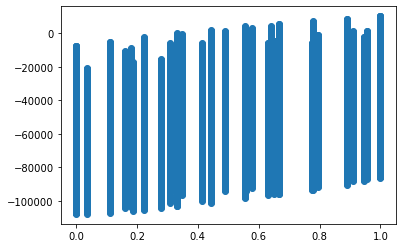

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(res.Y[..., 0], res.GM)

In [41]:
site_fractions = res.Y.values
print(site_fractions.shape)

(1, 1, 130, 84, 4)


In [42]:
filtered = res.drop_vars('component').to_dataframe()[['Y', 'GM']] \
                .unstack('internal_dof')\
                .droplevel(level='component')\
                .drop_duplicates()\
                .reset_index()\
                .drop(columns=['N', 'P', 'points'])
filtered = res.drop_vars('component').to_dataframe()[['Y', 'GM']] \
                .unstack('internal_dof')\
                .droplevel(level='component')\
                .reset_index().drop(columns=['N', 'P', 'points'])
print(filtered.shape)
# Not sure how to fix the duplicate energy column yet
filtered = filtered.values[:, :1+site_fractions.shape[-1]+1]
x_orig = filtered[:, :-1]
y_orig = filtered[:, -1]

(21840, 9)


C:\Users\rotis\AppData\Local\Continuum\anaconda3\envs\calphad\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [43]:
filtered

array([[ 3.00000000e+02,  1.00000000e+00,  1.00000000e-14,
         1.00000000e+00,  1.00000000e-14, -4.80144222e+03],
       [ 3.00000000e+02,  1.00000000e+00,  1.00000000e-14,
         1.00000000e+00,  1.00000000e-14, -4.80144222e+03],
       [ 3.00000000e+02,  1.00000000e+00,  1.00000000e-14,
         1.00000000e-14,  1.00000000e+00,  1.02039208e+04],
       ...,
       [ 1.59000000e+03,  4.12631494e-01,  5.87368506e-01,
         4.93614792e-01,  5.06385208e-01, -1.00158221e+05],
       [ 1.59000000e+03,  6.51435541e-01,  3.48564459e-01,
         6.66986448e-01,  3.33013552e-01, -9.60378628e+04],
       [ 1.59000000e+03,  6.51435541e-01,  3.48564459e-01,
         6.66986448e-01,  3.33013552e-01, -9.60378628e+04]])

In [44]:
class ConcatLayer(Layer):
    def __init__(self, temp_scale=1.0):
        super().__init__()
        self.temp_scale = float(temp_scale)
    def build(self, input_shape):
        self.scale_factor = tf.constant([1./self.temp_scale] + ([1.0] * (input_shape[-1]-1)))
    def call(self, inputs):
        scaled_inputs = inputs * self.scale_factor
        return scaled_inputs
        #return tf.concat([scaled_inputs, tf.math.log(scaled_inputs[..., :1])], axis=-1)

In [46]:
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
from tensorflow_addons.layers import PolynomialCrossing

x = x_orig.copy()
#x[:, 0] /= x_orig[:, 0].std()
print('Number of training points: ', x.shape[0])
y_unscaled = y_orig #- 8.3145 * x_orig[:, 0] * (x_orig[:, 1] * np.log(x_orig[:, 1]) + x[:, 2] * np.log(x_orig[:, 2]))
y = y_unscaled #/ y_unscaled.std() # (y_unscaled - y_unscaled.mean())/y_unscaled.std()
print('Number of features: ', x.shape[1])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1769)
inputs = Input(shape=(x.shape[1],))
x0 = ConcatLayer(temp_scale=x_orig[:, 0].max())(inputs)
#x0 = inputs
#x0 = BatchNormalization()(x0)
output = PolynomialCrossing(projection_dim=None, use_bias=False)((x0, x0))
output = PolynomialCrossing(projection_dim=None, use_bias=False)((Dropout(0)(x0), output))
output = PolynomialCrossing(projection_dim=None, use_bias=False)((Dropout(0)(x0), output))
output = PolynomialCrossing(projection_dim=None, use_bias=False)((Dropout(0)(x0), output))

output = y_unscaled.std() * tf.math.reduce_sum(output, axis=-1) + \
    8.3145*inputs[...,0] * (2*inputs[...,1]*tf.math.log(inputs[...,1]) + 2*inputs[...,2]*tf.math.log(inputs[...,2]) + \
                             inputs[...,3]*tf.math.log(inputs[...,3]) + inputs[...,4]*tf.math.log(inputs[...,4]))
linear_model = Model(inputs, output)
#linear_model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True), loss='mse')
linear_model.compile(optimizer='adam', loss='mae')

Number of training points:  21840
Number of features:  5


In [47]:
ConcatLayer(temp_scale=x_orig[:, 0].max())(x_test)

<tf.Tensor: shape=(2184, 5), dtype=float32, numpy=
array([[8.6163521e-01, 3.3333334e-01, 6.6666669e-01, 9.9999998e-15,
        1.0000000e+00],
       [3.2704401e-01, 6.6666669e-01, 3.3333334e-01, 6.6666669e-01,
        3.3333334e-01],
       [8.9308172e-01, 9.4639462e-01, 5.3605370e-02, 7.6818621e-01,
        2.3181379e-01],
       ...,
       [4.0880501e-01, 9.9999998e-15, 1.0000000e+00, 1.0000000e+00,
        9.9999998e-15],
       [4.5283020e-01, 1.0000000e+00, 9.9999998e-15, 1.0000000e+00,
        9.9999998e-15],
       [2.7044025e-01, 1.0000000e+00, 9.9999998e-15, 8.8888890e-01,
        1.1111111e-01]], dtype=float32)>

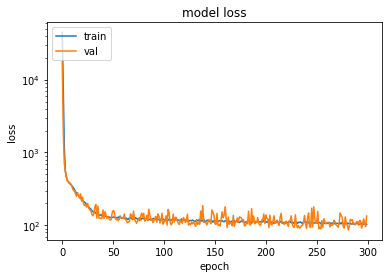

In [48]:
# Fit on training data
history = linear_model.fit(x=x_train, y=y_train, epochs=300, validation_data=(x_test, y_test), verbose=0,
                           callbacks=keras.callbacks.TerminateOnNaN())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

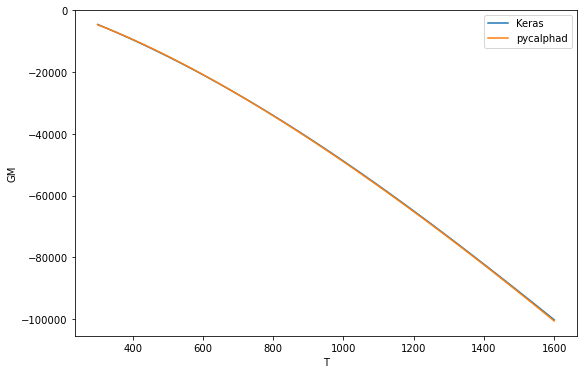

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import pycalphad

fig = plt.figure(figsize=(9,6))
ax = fig.gca()
def plot_at_composition(x_mg_1, x_mg_2):
    x_start = np.array([300,x_mg_1, 1-x_mg_1, x_mg_2, 1-x_mg_2])
    x_end = np.array([1600, x_mg_1, 1-x_mg_1, x_mg_2, 1-x_mg_2])
    x_interp = np.linspace(x_start, x_end, num=50)
    model_y = linear_model.predict(x_interp, batch_size=1)
    mod = pycalphad.Model(dbf, comps, 'MGZN2')
    test_calc = calculate(dbf, comps, 'MGZN2',model=mod, T=x_interp[:,0], N=1, P=1e5,
                          points=[[x_mg_1, 1-x_mg_1, x_mg_2, 1-x_mg_2]])
    #test_calc
    ax.plot(x_interp[:,0], model_y, label=f'Keras')
    ax.plot(x_interp[:,0], np.squeeze(test_calc.GM.values),
            label=f'pycalphad')
#plot_at_composition(0.2)
#plot_at_composition(0.4)
plot_at_composition(0.4, 0.4)
ax.set_xlabel('T')
ax.set_ylabel('GM')
ax.legend()

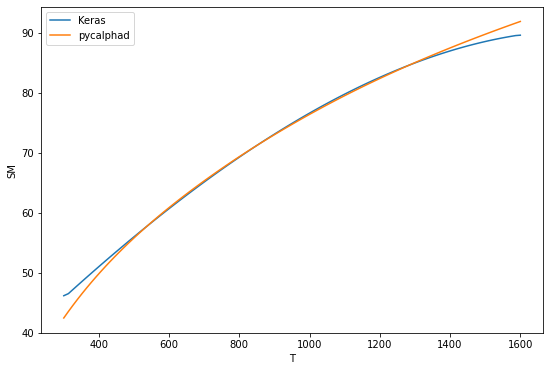

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import pycalphad

fig = plt.figure(figsize=(9,6))
ax = fig.gca()
def plot_entropy_at_composition(x_mg_1, x_mg_2):
    x_start = np.array([300,x_mg_1, 1-x_mg_1, x_mg_2, 1-x_mg_2])
    x_end = np.array([1600, x_mg_1, 1-x_mg_1, x_mg_2, 1-x_mg_2])
    x_interp = np.linspace(x_start, x_end, num=100)
    model_y = linear_model.predict(x_interp, batch_size=1)
    mod = pycalphad.Model(dbf, comps, 'MGZN2')
    test_calc = calculate(dbf, comps, 'MGZN2',model=mod, T=x_interp[:,0], N=1, P=1e5,
                          points=[[x_mg_1, 1-x_mg_1, x_mg_2, 1-x_mg_2]], output='SM')
    #test_calc
    ax.plot(x_interp[:,0], -np.gradient(model_y, x_interp[:,0]), label=f'Keras')
    ax.plot(x_interp[:,0], np.squeeze(test_calc.SM.values),
            label=f'pycalphad')
#plot_at_composition(0.2)
#plot_at_composition(0.4)
plot_entropy_at_composition(0.8, 0.1)
ax.set_xlabel('T')
ax.set_ylabel('SM')
ax.legend()

Text(0, 0.5, 'delta GM')

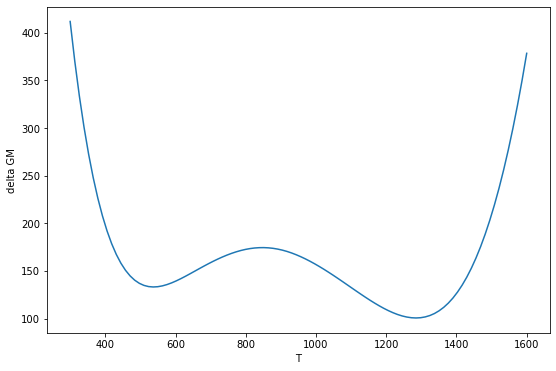

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
import pycalphad

fig = plt.figure(figsize=(9,6))
ax = fig.gca()
def plot_error_at_composition(x_mg_1, x_mg_2):
    x_start = np.array([300,x_mg_1, 1-x_mg_1, x_mg_2, 1-x_mg_2])
    x_end = np.array([1600, x_mg_1, 1-x_mg_1, x_mg_2, 1-x_mg_2])
    x_interp = np.linspace(x_start, x_end, num=100)
    model_y = linear_model.predict(x_interp, batch_size=1)
    mod = pycalphad.Model(dbf, comps, 'MGZN2')
    test_calc = calculate(dbf, comps, 'MGZN2',model=mod, T=x_interp[:,0], N=1, P=1e5,
                          points=[[x_mg_1, 1-x_mg_1, x_mg_2, 1-x_mg_2]])
    #test_calc
    ax.plot(x_interp[:,0], np.abs(model_y-np.squeeze(test_calc.GM.values)))
#plot_at_composition(0.2)
#plot_at_composition(0.4)
plot_error_at_composition(0.8, 0.1)
ax.set_xlabel('T')
ax.set_ylabel('delta GM')

In [57]:
linear_model.weights

[<tf.Variable 'polynomial_crossing_12/kernel:0' shape=(5, 5) dtype=float32, numpy=
 array([[ 0.25856012, -0.77056736, -0.26322895, -0.13555054, -0.07270886],
        [-0.05381608, -0.35304284, -0.9327058 , -0.2778642 , -0.3241926 ],
        [ 0.46853676,  0.4037043 ,  0.0421323 , -0.66948676, -0.02388394],
        [ 0.19579415, -0.29969388, -0.11727678, -0.1905693 ,  0.1411309 ],
        [ 0.09108384, -0.02203372, -0.3144134 , -1.0624331 , -0.29124516]],
       dtype=float32)>,
 <tf.Variable 'polynomial_crossing_13/kernel:0' shape=(5, 5) dtype=float32, numpy=
 array([[ 0.20256443, -0.33473045, -0.02885799, -0.06276319, -0.18144524],
        [ 0.25406343, -0.17309037,  1.4423554 , -0.2346512 , -0.07729133],
        [ 0.5147015 , -0.27912197, -0.97245985, -0.60306746,  0.01987143],
        [ 0.26696336, -0.20819955,  0.03503828, -0.934001  , -0.3601887 ],
        [-0.18022333,  0.13617878, -0.6245673 , -0.09973283, -0.10126442]],
       dtype=float32)>,
 <tf.Variable 'polynomial_crossing